# FinGPT: Training with LoRA and Meta-Llama-3-8B

## Part 1: Preparing the Data

### 1.1 Initialize Directories

In [ ]:
hf_token = "Your HF token" #Put your own HF token here, do not publish it
from huggingface_hub import login
# Login directly with your Token (remember not to share this Token publicly)
login(token=hf_token)

In [ ]:
import os
import shutil

In [ ]:
if not os.path.exists('./data'):
    os.makedirs('./data')


jsonl_path = "../data/dataset_new.jsonl"
save_path = '../data/dataset_new'


if os.path.exists(jsonl_path):
    os.remove(jsonl_path)

if os.path.exists(save_path):
    shutil.rmtree(save_path)

directory = "../data"
if not os.path.exists(directory):
    os.makedirs(directory)

In [ ]:
!ls -l ./data/dataset_new

ls: cannot access './data/dataset_new': No such file or directory


### 1.2 Load and Prepare Dataset

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from datasets import load_dataset
import datasets

In [ ]:
dic = {
    0:'negative',
    1:'positive',
    2:'neutral'
}

In [ ]:
tfns = load_dataset('zeroshot/twitter-financial-news-sentiment') #tfns = Twitter Financial News Sentiment

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

sent_train.csv:   0%|          | 0.00/859k [00:00<?, ?B/s]

sent_valid.csv:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [ ]:
tfns = tfns['train']
tfns = tfns.to_pandas()

tfns['label'] = tfns['label'].apply(lambda x : dic[x])  # Map numerical labels to their corresponding sentiments

#Add instruction for each data entry, which is crucial for Instruction Tuning.
tfns['instruction'] = 'What is the sentiment of this tweet? Please choose an answer from {negative/neutral/positive}.'
tfns.columns = ['input','output','instruction']

#Convert the Pandas dataframe back to a Hugging Face Dataset object.
tfns = datasets.Dataset.from_pandas(tfns)
tfns

Dataset({
    features: ['input', 'output', 'instruction'],
    num_rows: 9543
})

### 1.3 Concatenate and Shuffle Dataset

In [ ]:
tmp_dataset = datasets.concatenate_datasets([tfns]*2) #Creat a list that contains 2 tfns
train_dataset = tmp_dataset
print(tmp_dataset.num_rows)

19086


In [ ]:
all_dataset = train_dataset.shuffle(seed = 42)
all_dataset.shape

(19086, 3)

The training data is all set

## Part 2: Dataset Formatting and Tokenization

### 2.1 Dataset Fromatting

You must structure your data in a specific format that aligns with the training process.

In [ ]:
import json
from tqdm.notebook import tqdm
# Used to display a progress bar in Jupyter Notebook to help visualize the progress of data processing

In [ ]:
def format_examle(example:dict) -> dict:    #Defines a function named format_example that takes a dictionary as input (example: dict) and returns a dictionary (-> dict).
  context = f"Instruction:{example['instruction']}\n"   #Initializes a string variable context using an f-string to format the instruction.
  if example.get('input'):     #Checks if the example dictionary has an input key and whether it contains a value.
    context += f"Input:{example['input']}\n"
  context += 'Answer: '
  target = example['output']
  return {"context": context , "target":target}  # This is the format of json data.



data_list = []
for item in all_dataset.to_pandas().itertuples():    #Iterates over each row of the dataset all_dataset, which has been converted into a Pandas DataFrame using .to_pandas().
  tmp = {}
  tmp['instruction'] = item.instruction
  tmp['input'] = item.input
  tmp['output'] = item.output
  data_list.append(tmp)

This is what the elements in data_list look like before formatting

---



In [ ]:
data_list[0]

{'instruction': 'What is the sentiment of this tweet? Please choose an answer from {negative/neutral/positive}.',
 'input': '$DRIP $LABU $GASX - SOXL, LABU, JO and GUSH among weekly ETF movers https://t.co/FntrWNY9sn',
 'output': 'neutral'}

In [ ]:
# save to a json file
with open("../data/dataset_new.jsonl",'w') as f:
  for example in tqdm(data_list,desc = 'formatting..'):
    f.write(json.dumps(format_examle(example)) + '\n')

formatting..:   0%|          | 0/19086 [00:00<?, ?it/s]

In [ ]:
json_data_list = []  # Var to save json data

# Save to a jsonl file and store in json_data_list
with open("../data/dataset_new.jsonl", 'r') as f:
    for line in f:
        json_line = json.loads(line.strip())
        json_data_list.append(json_line)

This is what it is look like after formatting

In [ ]:
json_data_list[0]

{'context': 'Instruction:What is the sentiment of this tweet? Please choose an answer from {negative/neutral/positive}.\nInput:$DRIP $LABU $GASX - SOXL, LABU, JO and GUSH among weekly ETF movers https://t.co/FntrWNY9sn\nAnswer: ',
 'target': 'neutral'}

In [ ]:
json_data_list[0]['context']

'Instruction:What is the sentiment of this tweet? Please choose an answer from {negative/neutral/positive}.\nInput:$DRIP $LABU $GASX - SOXL, LABU, JO and GUSH among weekly ETF movers https://t.co/FntrWNY9sn\nAnswer: '

In [ ]:
json_data_list[0]['target']

'neutral'

login to HF to use Llama 3

### 2.2 Tokenization

Tokenization is the process of converting input text into tokens that can be fed into the model.

In [ ]:
## need to set the packages to run this code block
!pip install protobuf transformers==4.30.2 cpm_kernels torch>=2.0 gradio mdtex2html sentencepiece accelerate

In [ ]:
from transformers import AutoTokenizer, AutoConfig

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
model_name = 'meta-llama/Meta-Llama-3-8B'   #Specifies the model you're working with
jsonl_path = '../data/dataset_new.jsonl'
save_path = '../data/dataset_new'    #The path where the processed dataset will be saved after tokenization or any other processing
max_seq_length = 512    #Maximum sequence length for the inputs. If an input exceeds this length, it will either be truncated or skipped.
skip_overlength = True    #A flag that determines whether to skip overlength examples that exceed max_seq_length

This preprocess function tokenizes the promt and target, combines them into Input ids, trims or pads the squence to the maximum squence length.

In [ ]:
def preprocess(tokenizer, config, example, max_seq_length):
  prompt = example['context']
  target = example['target']
  prompt_ids = tokenizer.encode(   #ids refers to the numerical identifiers that correspond to tokens.These token ids are what the model processes, as models require numerical input rather than raw text.
      prompt,
      max_length = max_seq_length,
      truncation = True
      )
  target_ids = tokenizer.encode(
      target,
      max_length = max_seq_length,
      truncation = True,
      add_special_tokens = False
      )
  input_ids = prompt_ids + target_ids + [config.eos_token_id]  #[config.eos_token_id] is a sign that marks the end of the list.
  return {'input_ids':input_ids,'seq_len':len(prompt_ids)}

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
config = AutoConfig.from_pretrained(model_name, trust_remote_code=True, device_map='auto')

In [ ]:
example = json_data_list[0]
prompt = example['context']
target = example['target']

In [ ]:
example['target']

'neutral'

input_ids is a complete list of token IDs that combines the input sentence (prompt), the target sentence (target), and the end-of-sequence token (eos_token_id).
This list is fed into the model for training or inference. The model uses these IDs to understand and process the input and generate the corresponding output.

The read_jsonl function reads each line from the JSONL file, preprocesses it using the preprocess function,
and then yields each preprocessed example.

In [ ]:
def read_jsonl(path, max_seq_length, skip_overlength=False):
    tokenizer = AutoTokenizer.from_pretrained(    #Initializes a tokenizer using a pre-trained model specified by model_name.
        model_name, trust_remote_code=True)
    config = AutoConfig.from_pretrained(    #Loads the configuration for the model. device_map='auto' helps automatically map the model to available devices (e.g., GPU or CPU).
        model_name, trust_remote_code=True, device_map='auto')
    with open(path, "r") as f:
        for line in tqdm(f.readlines()):
            example = json.loads(line)
            #Preprocesses each example by tokenizing it and converting it into input_ids using the preprocess() function,
            #which takes the tokenizer, config, example, and max_seq_length as inputs.
            feature = preprocess(tokenizer, config, example, max_seq_length)
            if skip_overlength and len(feature["input_ids"]) > max_seq_length:
                continue
            feature["input_ids"] = feature["input_ids"][:max_seq_length]  #Truncates the input_ids to ensure they do not exceed max_seq_length.
            yield feature
#Uses yield to return one preprocessed feature at a time, making the function a generator.
#This allows you to iterate over the processed features one by one without loading everything into memory at once.

### 2.3 Save the Dataset

In [ ]:
save_path = './data/dataset_new'

In [ ]:
dataset = datasets.Dataset.from_generator(
    lambda: read_jsonl(jsonl_path, max_seq_length, skip_overlength)
    )
dataset.save_to_disk(save_path)

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/19086 [00:00<?, ?it/s]

Saving the dataset (0/1 shards):   0%|          | 0/19086 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk

# Load Dataset
loaded_dataset = load_from_disk('./data/dataset_new')

# Check the structure of Dataset
print(loaded_dataset)

# Print the first sample of the dataset
print(loaded_dataset['input_ids'][0])

### 2.4 Save dataset to your own google drive

Every time you restart colab, you don't have to reformat the data, you can just load the formatted data directly from this google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #You'll be asked to authorize access to your Google Drive

Mounted at /content/drive


In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/AI4Finance/FinGPT/FinGPT: Training with LoRA and Llama-3/dataset_new' #Change to your own address
# Write your own Google drive saving address in xxxxxxxx part: '/content/drive/MyDrive/xxxxxxxxxxxxxxxxx/dataset_new'
dataset.save_to_disk(save_path)

Saving the dataset (0/1 shards):   0%|          | 0/19086 [00:00<?, ? examples/s]

### 2.5 Load Dataset from google drive

Runs directly from here every time you re-login or reconnect.

In [ ]:
from huggingface_hub import login


# Login directly with your Token (remember not to share this Token publicly)
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!pip install datasets
from datasets import load_from_disk
from google.colab import drive

drive.mount('/content/drive') #You'll be asked to authorize access to your Google Drive

save_path = '/content/drive/MyDrive/Colab Notebooks/AI4Finance/FinGPT/FinGPT: Training with LoRA and Llama-3/dataset_new' #Change to your own address
# Load saved dataset
loaded_dataset = load_from_disk(save_path)

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
Mounted at /

In [ ]:
# Check the structure of Dataset
print(loaded_dataset)

# Print the first sample of the dataset
print(loaded_dataset['input_ids'][0])

Dataset({
    features: ['input_ids', 'seq_len'],
    num_rows: 19086
})
[128000, 17077, 25, 3923, 374, 279, 27065, 315, 420, 12072, 30, 5321, 5268, 459, 4320, 505, 314, 43324, 14, 60668, 14, 31587, 28374, 2566, 22444, 7842, 3378, 400, 20257, 52, 400, 38, 1950, 55, 482, 5745, 37630, 11, 32074, 52, 11, 10458, 323, 480, 20088, 4315, 17496, 54163, 96454, 3788, 1129, 83, 6973, 12598, 77, 376, 54, 23923, 24, 9810, 198, 16533, 25, 220, 60668, 128001]


The output of this code block above should be:

Dataset({
  
    features: ['input_ids', 'seq_len'],

    num_rows: 19086

})

[128000, 17077, 25, 3923, 374, 279, 27065, 315, 420, 12072, 30, 5321, 5268, 459, 4320, 505, 314, 43324, 14, 60668, 14, 31587, 28374, 2566, 22444, 7842, 3378, 400, 20257, 52, 400, 38, 1950, 55, 482, 5745, 37630, 11, 32074, 52, 11, 10458, 323, 480, 20088, 4315, 17496, 54163, 96454, 3788, 1129, 83, 6973, 12598, 77, 376, 54, 23923, 24, 9810, 198, 16533, 25, 220, 60668, 128001]

说明数据正确的被加载

## Part 3: Setup FinGPT training with LoRA and Llama-3


### 3.1 Training Arguments Setup:
Initialize and set training arguments.

In [ ]:
!pip install accelerate
!pip install -U bitsandbytes
!pip install loguru
!pip install --upgrade peft
!pip install transformers==4.40.1

  Using cached transformers-4.40.1-py3-none-any.whl.metadata (137 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached transformers-4.40.1-py3-none-any.whl (9.0 MB)
Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2


In [ ]:
from typing import List, Dict, Optional
import torch
from loguru import logger
from transformers import (
    AutoModel,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    BitsAndBytesConfig,
    AutoModelForCausalLM
)
from peft import (
    TaskType,
    LoraConfig,
    get_peft_model,
    set_peft_model_state_dict,
    prepare_model_for_kbit_training,
)
from peft.utils import TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING
from transformers import LlamaForCausalLM

Note: This will report error with newest torch and CUDA version.

is_bitsandbytes_available() will return False

 and will show:

ImportError: Using `load_in_8bit=True` requires Accelerate: `pip install accelerate` and the latest version of bitsandbytes `pip install -i https://test.pypi.org/simple/ bitsandbytes` or pip install bitsandbytes`  

 in model loading part.

Run

!pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio==0.13.1+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

first to adress the problem.

In [ ]:
training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Colab Notebooks/AI4Finance/FinGPT/FinGPT: Training with LoRA and Llama-3/finetuned_model/',    # Path to save the fine-tuned model
    logging_steps = 500,               # Log every 500 steps
    # max_steps=10000,                 # Maximum number of training steps (commented out, can be enabled)
    num_train_epochs = 2,              # Number of training epochs (train for 2 epochs)
    per_device_train_batch_size=4,     # Batch size of 4 for training on each device (GPU/CPU)
    gradient_accumulation_steps=8,     # Accumulate gradients for 8 steps before updating weights
    learning_rate=1e-4,                # Learning rate set to 1e-4
    weight_decay=0.01,                 # Weight decay (L2 regularization) set to 0.01
    warmup_steps=1000,                 # Warm up the learning rate for the first 1000 steps
    save_steps=500,                    # Save the model every 500 steps
    fp16=True,                         # Enable FP16 mixed precision training to save memory and speed up training
    # bf16=True,                       # Enable BF16 mixed precision training (commented out)
    torch_compile = False,             # Whether to enable Torch compile (`False` means not enabled)
    load_best_model_at_end = True,     # Load the best-performing model at the end of training
    evaluation_strategy="steps",       # Evaluation strategy is set to evaluate every few steps
    remove_unused_columns=False,       # Whether to remove unused columns during training (keep all columns)
)


### 3.2 Quantization Config Setup:
Set quantization configuration to reduce model size without losing significant precision.

In [ ]:
!pip list | grep bitsandbytes

bitsandbytes                     0.44.0


In [ ]:
# quantitative allocation
q_config = BitsAndBytesConfig(load_in_4bit=False,
                                bnb_4bit_quant_type='nf4',
                                bnb_4bit_use_double_quant=True,
                                bnb_4bit_compute_dtype=torch.float16
                                )

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

### 3.3 Model Loading & Preparation:
Load the base model and tokenizer, and prepare the model for INT8 training.

Runtime -> Change runtime type -> A100 GPU

Restart runtime and run again if not working

In [ ]:
model_name = "meta-llama/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
from transformers.utils import is_bitsandbytes_available
is_bitsandbytes_available()

True

In [ ]:
model = LlamaForCausalLM.from_pretrained(
        model_name,
        quantization_config = q_config,
        trust_remote_code=True,
        device_map='auto'
    )

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### 3.4 LoRA Config & Setup

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

# LoRA for Llama3
target_modules = TRANSFORMERS_MODELS_TO_LORA_TARGET_MODULES_MAPPING['llama']  # Modules for the Llama model
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=target_modules,
    bias='none',
)

# Loading LoRA for Llama3 models using PEFT (Parameter-Efficient Fine-Tuning)
model = get_peft_model(model, lora_config)

# Print the number of trainable parameters
print_trainable_parameters(model)

trainable params: 3407872 || all params: 4544008192 || trainable%: 0.07499704789264605


In [ ]:
resume_from_checkpoint = None
if resume_from_checkpoint is not None:
    checkpoint_name = os.path.join(resume_from_checkpoint, 'pytorch_model.bin')
    if not os.path.exists(checkpoint_name):
        checkpoint_name = os.path.join(
            resume_from_checkpoint, 'adapter_model.bin'
        )
        resume_from_checkpoint = False
    if os.path.exists(checkpoint_name):
        logger.info(f'Restarting from {checkpoint_name}')
        adapters_weights = torch.load(checkpoint_name)
        set_peft_model_state_dict(model, adapters_weights)
    else:
        logger.info(f'Checkpoint {checkpoint_name} not found')

In [ ]:
model.print_trainable_parameters()

trainable params: 3,407,872 || all params: 8,033,669,120 || trainable%: 0.0424


## Part 4: Loading Data and Training FinGPT


In this segment, we'll delve into the loading of your pre-processed data, and finally, launch the training of your FinGPT model. Here's a stepwise breakdown of the script provided:



*   Need to purchase Google Colab GPU plans, Colab Pro is
sufficient or just buy 100 compute units for $10



### 4.1 Loading Your Data:

In [ ]:
# load data
from datasets import load_from_disk
import datasets
from google.colab import drive

drive.mount('/content/drive') # You will be asked to authorize access to your Google Drive

save_path = '/content/drive/MyDrive/Colab Notebooks/AI4Finance/FinGPT/FinGPT: Training with LoRA and Llama-3/dataset_new'
# Load saved dataset
dataset = load_from_disk(save_path)
dataset = dataset.train_test_split(0.2, shuffle=True, seed = 42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 4.2 Training Configuration and Launch:



*   Customize the Trainer class for specific loss computation, prediction step, and model-saving methods.
*   Define a data collator function to process batches of data during training.
*   Set up TensorBoard for logging, instantiate your modified trainer, and begin training.




In [ ]:
import torch.nn.functional as F

In [ ]:
def data_collator(features: list) -> dict:
    # Check if pad_token_id is None, if it is then use eos_token_id as the padding value
    if tokenizer.pad_token_id is None:
        pad_token_id = tokenizer.eos_token_id  # Use eos_token_id as a fill symbol
    else:
        pad_token_id = tokenizer.pad_token_id

    len_ids = [len(feature["input_ids"]) for feature in features]
    longest = max(len_ids)

    input_ids = []
    labels_list = []

    for ids_l, feature in sorted(zip(len_ids, features), key=lambda x: -x[0]):
        ids = feature["input_ids"]
        seq_len = feature["seq_len"]

        # Padding with calculated pad_token_id
        labels = (
            [pad_token_id] * (seq_len - 1) + ids[(seq_len - 1) :] + [pad_token_id] * (longest - ids_l)
        )
        ids = ids + [pad_token_id] * (longest - ids_l)

        _ids = torch.LongTensor(ids)
        labels_list.append(torch.LongTensor(labels))
        input_ids.append(_ids)

    input_ids = torch.stack(input_ids)
    labels = torch.stack(labels_list)

    return {
        "input_ids": input_ids,
        "labels": labels,
    }

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from transformers.integrations import TensorBoardCallback

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 创建保存路径
import os

output_dir = '/content/drive/MyDrive/Colab Notebooks/AI4Finance/FinGPT/FinGPT: Training with LoRA and Llama-3/Model/' # Use your own address
os.makedirs(output_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Train
# Took about 10 compute units
writer = SummaryWriter()
trainer = ModifiedTrainer(
    model=model,
    args=training_args,             # Trainer args
    train_dataset=dataset["train"], # Training set
    eval_dataset=dataset["test"],   # Testing set
    data_collator=data_collator,    # Data Collator
    callbacks=[TensorBoardCallback(writer)],
)
trainer.train()
writer.close()


# Save model to Google Drive
model.save_pretrained(output_dir)

You are adding a <class 'transformers.integrations.integration_utils.TensorBoardCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
TensorBoardCallback


Step,Training Loss,Validation Loss
500,2.355200,0.004615


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Now your model is trained and saved! You can download it and use it for generating financial insights or any other relevant tasks in the finance domain. The usage of TensorBoard allows you to deeply understand and visualize the training dynamics and performance of your model in real-time.

## Part 5: Inference and Benchmarks using FinGPT

Now that your model is trained, let’s understand how to use it to infer and run benchmarks.


*   Took about 10 compute units




### 5.1 Load the model

In [ ]:
!pip install transformers==4.40.1 peft==0.4.0
!pip install sentencepiece
!pip install accelerate
!pip install torch
!pip install peft
!pip install datasets
!pip install bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 3.6 MB/s eta 0:00:00
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 78.9 MB/s eta 0:00:00
Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2


In [ ]:
#clone the FinNLP repository
!git clone https://github.com/AI4Finance-Foundation/FinNLP.git


import sys
sys.path.append('/content/FinNLP/')

fatal: destination path 'FinNLP' already exists and is not an empty directory.


In [ ]:
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, LlamaForCausalLM
from peft import PeftModel
import torch

# Load benchmark datasets from FinNLP
from finnlp.benchmarks.fpb import test_fpb
from finnlp.benchmarks.fiqa import test_fiqa , add_instructions
from finnlp.benchmarks.tfns import test_tfns
from finnlp.benchmarks.nwgi import test_nwgi

In [ ]:
# load model from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Fine-tuned PEFT model paths
path_to_check = '/content/drive/MyDrive/Colab Notebooks/AI4Finance/FinGPT/FinGPT: Training with LoRA and Llama-3/Model/'

# Check if the specified path exists
if os.path.exists(path_to_check):
    print("Path exists.")
else:
    print("Path does not exist.")

Path exists.


In [ ]:
from transformers import AutoModelForSequenceClassification

In [ ]:
from huggingface_hub import login

# login into hf
login(token=hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:

def eval_with_PEFT_model(base_model,peft_model):


  # Loda tokenizer
  tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code=True)
  tokenizer.pad_token = tokenizer.eos_token  # Use eos_token as pad_token
  tokenizer.padding_side = 'left'  # Important: Set as left padding


  model = LlamaForCausalLM.from_pretrained(base_model,
                                          trust_remote_code=True,
                                          load_in_8bit=True,
                                          device_map="cuda:0")  #Set the model to GPU

  # load peft's fine-tuned model weights
  model = PeftModel.from_pretrained(model, peft_model)

  return model.eval(), tokenizer

In [ ]:
base_model = "meta-llama/Meta-Llama-3-8B" # Loading the Llama base model and supporting text-generated models
peft_model = path_to_check  # Fine-tuned PEFT model paths

model,tokenizer = eval_with_PEFT_model(base_model,peft_model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

Compar with FinGPT/fingpt-mt_llama2-7b_lora

### 5.2 Run Benchmarks:

In [ ]:
batch_size = 8
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

In [ ]:
# TFNS Test Set, len 2388
# Available: 99.4 compute units
res_tfns = test_tfns(model, tokenizer, batch_size = batch_size)
# Available: 98.9 compute units
# Took about 0.5 compute unite to inference



Prompt example:
Instruction: What is the sentiment of this tweet? Please choose an answer from {negative/neutral/positive}.
Input: $ALLY - Ally Financial pulls outlook https://t.co/G9Zdi1boy5
Answer: 


Total len: 2388. Batchsize: 8. Total steps: 299


100%|██████████| 299/299 [02:54<00:00,  1.72it/s]

Acc: 0.8722780569514238. F1 macro: 0.8402673886325015. F1 micro: 0.8722780569514238. F1 weighted (BloombergGPT): 0.8720658580768996. 



These data are the results from the first time I evaluated the model, and there will be a slight difference in the results from each evaluation



Acc: 0.8693467336683417.

 F1 macro: 0.8359552714052252.

  F1 micro: 0.8693467336683417.
  
   F1 weighted (BloombergGPT): 0.8687621695747597.

In [ ]:
# FPB, len 1212
res_fpb = test_fpb(model, tokenizer, batch_size = batch_size)



Prompt example:
Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}.
Input: L&T has also made a commitment to redeem the remaining shares by the end of 2011 .
Answer: 


Total len: 1212. Batchsize: 8. Total steps: 152


100%|██████████| 152/152 [01:32<00:00,  1.65it/s]

Acc: 0.7962046204620462. F1 macro: 0.773422931317668. F1 micro: 0.7962046204620462. F1 weighted (BloombergGPT): 0.7893973143842868. 


These data are the results from the first time I evaluated the model, and there will be a slight difference in the results from each evaluation

Acc: 0.7871287128712872.

 F1 macro: 0.7579588995487127.

  F1 micro: 0.7871287128712872.
  
   F1 weighted (BloombergGPT): 0.7800606607353107.

In [ ]:
# FiQA, len 275
res_fiqa = test_fiqa(model, tokenizer, prompt_fun = add_instructions, batch_size = batch_size)



Prompt example:
Instruction: What is the sentiment of this tweet? Please choose an answer from {negative/neutral/positive}.
Input: This $BBBY stock options trade would have more than doubled your money https://t.co/Oa0loiRIJL via @TheStreet
Answer: 


Total len: 275. Batchsize: 8. Total steps: 35


100%|██████████| 35/35 [00:20<00:00,  1.70it/s]

Acc: 0.5709090909090909. F1 macro: 0.5521739781521845. F1 micro: 0.5709090909090909. F1 weighted (BloombergGPT): 0.6595857369778902. 


These data are the results from the first time I evaluated the model, and there will be a slight difference in the results from each evaluation

Note: Because this test set is small, there may be a 5% difference in the results of each evaluation (which will fluctuate to a greater degree than the other three)

Acc: 0.5927272727272728.

F1 macro: 0.5671120555501894.

F1 micro: 0.5927272727272728.

F1 weighted (BloombergGPT): 0.6808921202754874.

In [ ]:
# NWGI, len 4047
res_nwgi = test_nwgi(model, tokenizer, batch_size = batch_size)



Prompt example:
Instruction: What is the sentiment of this news? Please choose an answer from {negative/neutral/positive}.
Input: In the latest trading session, Adobe Systems (ADBE) closed at $535.98, marking a +0.31% move from the previous day.
Answer: 


Total len: 4047. Batchsize: 8. Total steps: 506


100%|██████████| 506/506 [05:05<00:00,  1.66it/s]

Acc: 0.6073634791203361. F1 macro: 0.6156173294062645. F1 micro: 0.6073634791203361. F1 weighted (BloombergGPT): 0.607180032313506. 


Acc: 0.6085989621942179.

 F1 macro: 0.6165752620869043.

  F1 micro: 0.6085989621942179.
  
   F1 weighted (BloombergGPT): 0.6087071466135167.

In [ ]:
res_nwgi


,input,output,instruction,context,target,out_text,new_target,new_out
0,"In the latest trading session, Adobe Systems (...",neutral,What is the sentiment of this news? Please cho...,Instruction: What is the sentiment of this new...,neutral,neutral<|end_of_text|>,neutral,neutral
1,Tech stocks are down today after an antitrust ...,negative,What is the sentiment of this news? Please cho...,Instruction: What is the sentiment of this new...,negative,Negative<|end_of_text|>,negative,negative
2,Intel Corp is committing $20 billion to build ...,positive,What is the sentiment of this news? Please cho...,Instruction: What is the sentiment of this new...,positive,Positive<|end_of_text|>,positive,positive
3,High costs and supply chain disruptions are li...,negative,What is the sentiment of this news? Please cho...,Instruction: What is the sentiment of this new...,negative,negative<|end_of_text|>,negative,negative
4,AMD still seems set to generate significant gr...,positive,What is the sentiment of this news? Please cho...,Instruction: What is the sentiment of this new...,positive,positive<|end_of_text|>,positive,positive
...,...,...,...,...,...,...,...,...
4042,"Amazon.com Inc. AMZN, +1.08% has proposed on T...",negative,What is the sentiment of this news? Please cho...,Instruction: What is the sentiment of this new...,negative,Neutral<|end_of_text|>,negative,neutral
4043,Not everyone has thousands of dollars on hand ...,neutral,What is the sentiment of this news? Please cho...,Instruction: What is the sentiment of this new...,neutral,Positive<|end_of_text|>,neutral,positive
4044,Amazon has delivered strong advertising growth...,positive,What is the sentiment of this news? Please cho...,Instruction: What is the sentiment of this new...,positive,Positive<|end_of_text|>,positive,positive
4045,U.S. chip manufacturer SkyWater Technology Inc...,positive,What is the sentiment of this news? Please cho...,Instruction: What is the sentiment of this new...,positive,Positive<|end_of_text|>,positive,positive


In [ ]:
from sklearn.metrics import accuracy_score,f1_score
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def get_score(df):

  accuracy = accuracy_score(df['target'], df['new_out'])

  f1_macro = f1_score(df['target'], df['new_out'], average='macro')

  f1_weighted = f1_score(df['target'], df['new_out'], average='weighted')

  return round(accuracy,3), round(f1_macro,3), round(f1_weighted,3)


def form_socre_dic(dataset_name):
  score_list = get_score(dataset_name)

  score_dic = {
        'Accuracy': score_list[0],
        'F1_macro': score_list[1],
        'F1_weighted': score_list[2]
  }

  return score_dic

In [ ]:
  score_dic = {
        'TFNS': form_socre_dic(res_tfns),
        'FPB': form_socre_dic(res_fpb),
        'FIQA': form_socre_dic(res_fiqa),
        'NWGI': form_socre_dic(res_nwgi)
  }

In [ ]:
pd.DataFrame(score_dic)

,TFNS,FPB,FIQA,NWGI
Accuracy,0.872,0.796,0.571,0.607
F1_macro,0.840,0.773,0.552,0.616
F1_weighted,0.872,0.789,0.660,0.607


In [ ]:
score_dic

{'TFNS': {'Accuracy': 0.872, 'F1_macro': 0.84, 'F1_weighted': 0.872},
 'FPB': {'Accuracy': 0.796, 'F1_macro': 0.773, 'F1_weighted': 0.789},
 'FIQA': {'Accuracy': 0.571, 'F1_macro': 0.552, 'F1_weighted': 0.66},
 'NWGI': {'Accuracy': 0.607, 'F1_macro': 0.616, 'F1_weighted': 0.607}}

### 5.3 Result comparision

In [ ]:
#Results of other fine-tuned model come from previous tranning results.
results = {
    "TFNS": {
        "FinGPT-ChatGlm2-6b": {"Acc": 0.856, "F1_macro": 0.806, "F1_weighted": 0.850},
        "FinGPT-V3.1": {"Acc": 0.876, "F1_macro": 0.841, "F1_weighted":  0.875},
    },
    "FPB": {
        "FinGPT-ChatGlm2-6b": {"Acc": 0.741, "F1_macro": 0.655, "F1_weighted": 0.694},
        "FinGPT-V3.1": {"Acc": 0.856, "F1_macro": 0.841, "F1_weighted": 0.855},
    },
    "FIQA": {
        "FinGPT-ChatGlm2-6b": {"Acc": 0.48, "F1_macro": 0.5,  "F1_weighted": 0.49},
        "FinGPT-V3.1": {"Acc": 0.836, "F1_macro":0.746, "F1_weighted": 0.850},
    },
    "NWGI": {
        "FinGPT-ChatGlm2-6b": {"Acc": 0.521, "F1_macro": 0.500, "F1_weighted":0.490},
        "FinGPT-V3.1": {"Acc": 0.642, "F1_macro": 0.650,"F1_weighted": 0.642},
    },
}

In [ ]:
# Update the results dictionary to insert the value of FinGPT-Llama-8b.
for dataset_name, scores in score_dic.items():
    if dataset_name in results:

        if "FinGPT-Llama-8b" not in results[dataset_name]:
            results[dataset_name]["FinGPT-Llama-8b"] = {}

        results[dataset_name]["FinGPT-Llama-8b"].update({
            "Acc": scores['Accuracy'],
            "F1_macro": scores['F1_macro'],
            "F1_weighted": scores['F1_weighted']
        })

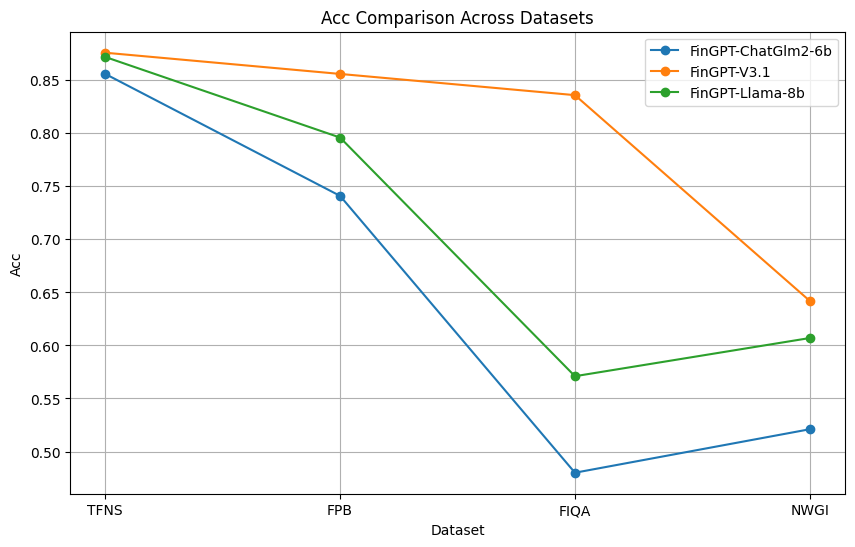

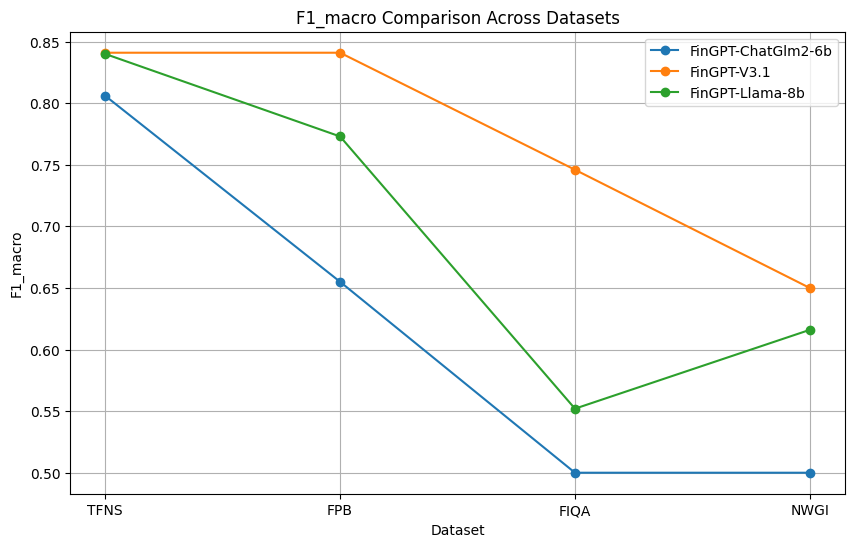

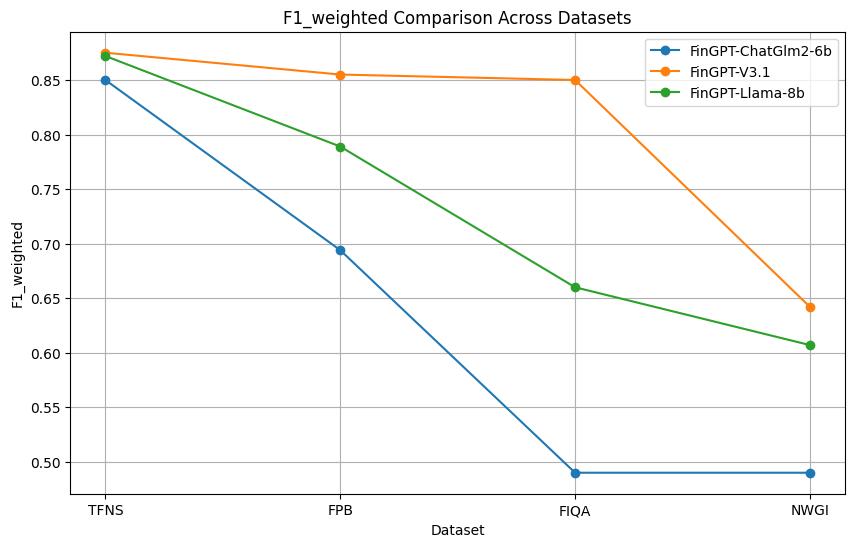

In [ ]:
data = []
for dataset, models in results.items():
    for model, metrics in models.items():
        data.append([dataset, model, metrics.get("Acc", None), metrics.get("F1_macro", None),
                     metrics.get("F1_micro", None), metrics.get("F1_weighted", None)])

df = pd.DataFrame(data, columns=["Dataset", "Model", "Acc", "F1_macro", "F1_micro", "F1_weighted"])

# visualization
def plot_metric(metric_name):
    plt.figure(figsize=(10, 6))
    for model in df["Model"].unique():
        subset = df[df["Model"] == model]
        plt.plot(subset["Dataset"], subset[metric_name], marker='o', label=model)
    plt.title(f"{metric_name} Comparison Across Datasets")
    plt.xlabel("Dataset")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualization of Accuracy, F1_macro and F1_weighted comparison
plot_metric("Acc")
plot_metric("F1_macro")
plot_metric("F1_weighted")

In [ ]:
# Transpose the data table so that the rows are datasets and the columns are models for Acc, F1_macro, and F1_weighted, respectively.


acc_df = df.pivot(index='Dataset', columns='Model', values='Acc')


f1_macro_df = df.pivot(index='Dataset', columns='Model', values='F1_macro')


f1_weighted_df = df.pivot(index='Dataset', columns='Model', values='F1_weighted')

In [ ]:
print("Accuracy DataFrame:")
acc_df

Accuracy DataFrame:


Model,FinGPT-ChatGlm2-6b,FinGPT-Llama-8b,FinGPT-V3.1
Dataset,,,
FIQA,0.480,0.571,0.836
FPB,0.741,0.796,0.856
NWGI,0.521,0.607,0.642
TFNS,0.856,0.872,0.876


In [ ]:
print("\nF1 Macro DataFrame:")
f1_macro_df


F1 Macro DataFrame:


Model,FinGPT-ChatGlm2-6b,FinGPT-Llama-8b,FinGPT-V3.1
Dataset,,,
FIQA,0.500,0.552,0.746
FPB,0.655,0.773,0.841
NWGI,0.500,0.616,0.650
TFNS,0.806,0.840,0.841


In [ ]:
print("\nF1 Weighted DataFrame:")
f1_weighted_df


F1 Weighted DataFrame:


Model,FinGPT-ChatGlm2-6b,FinGPT-Llama-8b,FinGPT-V3.1
Dataset,,,
FIQA,0.490,0.660,0.850
FPB,0.694,0.789,0.855
NWGI,0.490,0.607,0.642
TFNS,0.850,0.872,0.875
